In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import nibabel as nib
from nilearn.plotting import plot_stat_map, view_img
from nilearn.reporting import get_clusters_table
import glob
import os
import numpy as np
import pandas as pd

/Users/zeynepenkavi/.pyenv/versions/3.8.3/envs/py-dvl-fmri/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
from fmri_nb_helpers import get_img_path, get_filt_tval_img, plot_filt_tval_img, get_filt_diff_tval_img, plot_filt_diff_tval_img, get_mean_cor_df

# Regressor types

- ev = event; amplitude = 1  
- par = parametric; amplitude = demeaned    
- st = stick (0 duration); amplitude = 1 
- rt = reaction time; amplitude = demeaned RT

Citing Grinband et al. (2008) people agree that reaction times must be taken into account but model them in different ways. Schonberg, Poldrack et al. papers use overall response time for event and parametric regressor as well as a parametric RT regressor. Many in the rest of the decision making literature use boxcars with RT durations (e.g. Dunsmoor et al. (2011), Chang et al. (2011), Chang and Sanfey (2013), Shuck et al. (2016)). 

Since it is common to use boxcars with RT duration and I don't know others who model RT the way Poldrack et al. do I will present those results below.

# Building block models

## Model 1: fractalProb_ev + stim_ev + choiceShift_st + reward_ev

Correlation between regressors averaged across subjects and runs

In [ ]:
get_mean_cor_df(reg_rt = "0", mnum = "1")

In [ ]:
regs = ['fractalProb_ev', 'stim_ev', 'reward_ev']
mnum = '1'
for reg in regs:
    plot_filt_tval_img(reg, mnum = mnum)

Check for left motor cortex activity. Cross is the precentral gyrus peak reported in Hare et al.

In [ ]:
reg = 'choiceShift_st'
mnum = '1'
cut_coords = (-45, -34, 64)
draw_cross = True

plot_filt_tval_img(reg, mnum = mnum, cut_coords = cut_coords, draw_cross = draw_cross)

Motor cortex activity is a little ventral than expected but more consistent for choiceShift regressor. It is, however, not lateralized to the left.

## Model 1a: fractalProb_ev + stim_ev + choiceShiftLeft_st + choiceShiftRight_st + reward_ev

In [ ]:
plot_filt_diff_tval_img(reg="choiceShiftLeft_st", reg_rt1="0", reg_rt2="0", mnum1="1a", mnum2="1", reg2 = "choiceShift_st", cut_coords = cut_coords)
plot_filt_diff_tval_img(reg="choiceShiftRight_st", reg_rt1="0", reg_rt2="0", mnum1="1a", mnum2="1", reg2 = "choiceShift_st", cut_coords = cut_coords)
plot_filt_diff_tval_img(reg="choiceShiftRight_st", reg_rt1="0", reg_rt2="0", mnum1="1a", mnum2="1a", reg2 = "choiceShiftLeft_st", cut_coords = cut_coords)


## Model 2: Model 1 + fractalProb_par

In [ ]:
get_mean_cor_df(reg_rt = "0", mnum = "2")

In [ ]:
regs = ['fractalProb_ev', 'stim_ev', 'choiceShift_st', 'reward_ev']
mnum = '2'

for reg in regs:
#     plot_filt_diff_tval_img(reg, mnum1="1", mnum2=mnum)
    print('No interesting change from Model 1 for %s in Model %s'%(reg, mnum))

In [ ]:
reg = 'fractalProb_par'
mnum = '2'
plot_filt_tval_img(reg, mnum = mnum)

# Model 3: Model 2 + valBundleSum_par + valChosenMinusUnchosen_par + reward_ev + reward_par + rpeLeftRightSum_par

In [ ]:
get_mean_cor_df(reg_rt = "0", mnum = "3")

## Event regressors

Plotting tvalues filtered for corrected p values < 0.05
Plotting tvalues filtered for corrected p values < 0.05
Plotting tvalues filtered for corrected p values < 0.05
Plotting tvalues filtered for corrected p values < 0.05


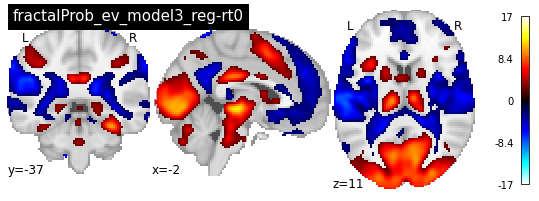

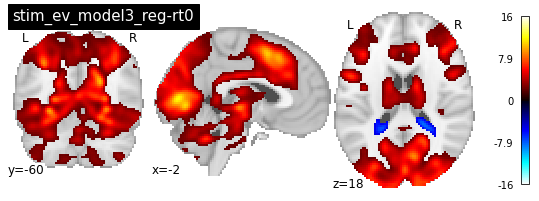

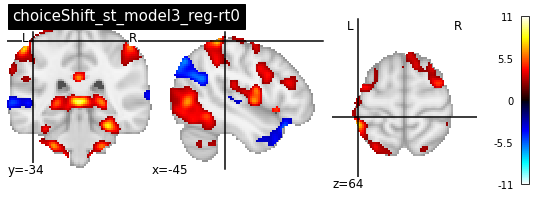

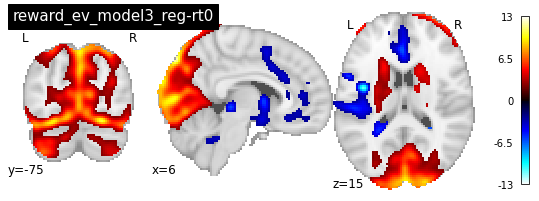

In [4]:
regs = ['fractalProb_ev', 'stim_ev', 'choiceShift_st', 'reward_ev']
mnum = '3'

for reg in regs:
    if reg == 'choiceShift_st':
        plot_filt_tval_img(reg, mnum = mnum, draw_cross=True, cut_coords = (-45, -34, 64))
    else:
        plot_filt_tval_img(reg, mnum = mnum)

## Parametric regressors

Plotting tvalues filtered for corrected p values < 0.05
Plotting tvalues filtered for corrected p values < 0.05
Nothing survives correction for valChosenMinusUnchosen_par, model = 3, tstat = 1, reg_rt = 0 at threshold p < 0.05
Plotting tvalues filtered for corrected p values < 0.05
Nothing survives correction for rpeLeftRightSum_par, model = 3, tstat = 1, reg_rt = 0 at threshold p < 0.05


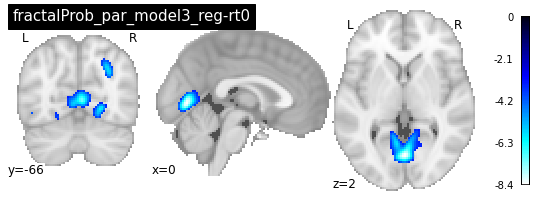

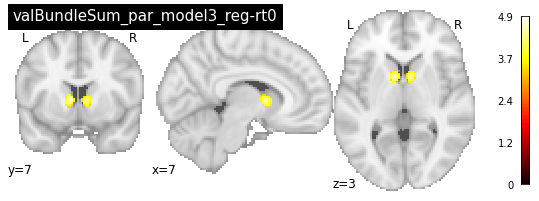

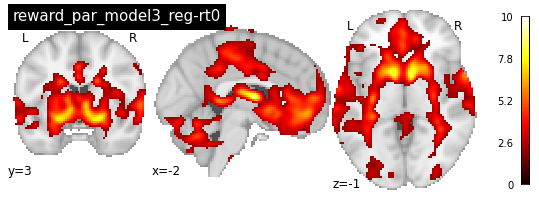

In [5]:
regs = ['fractalProb_par', 'valBundleSum_par', 'valChosenMinusUnchosen_par', 'reward_par', 'rpeLeftRightSum_par']
mnum = '3'
for reg in regs:
    plot_filt_tval_img(reg, mnum = mnum)

## What is going on with reward_par positive corrp? 

The filtered image looks slightly more reasonable than before but still the arbitrarily thresholded tmap suggests

- T values < 3 somehow survive the permutation tets above
- There are negative T's at a similar threshold that do not survive

Plotting tvalues filtered for corrected p values < 0.05


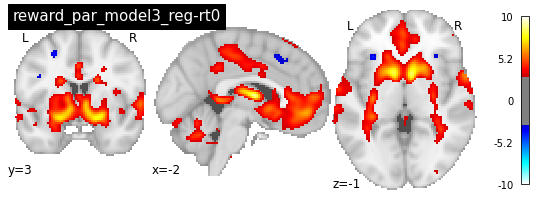

In [14]:
plot_filt_tval_img('reward_par', mnum = '3', nofilt=True, t_threshold=3, 
                   interactive=False, cut_coords = (-2, 3, -1), draw_cross=False)

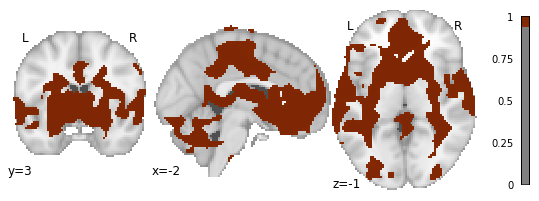

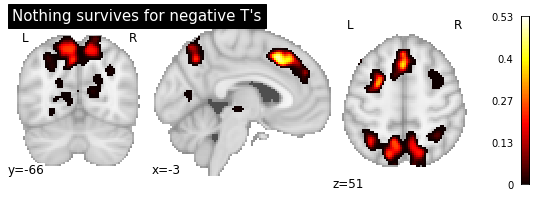

In [22]:
reg="reward_par"
reg_rt="0"
mnum="3"
mname="overall-mean"
tstat="1"

img_path = get_img_path(reg=reg, reg_rt=reg_rt, mnum=mnum, mname=mname)
pos_pval_fn = '%s_model%s_reg-rt%s_pos_%s_randomise_tfce_corrp_tstat%s.nii.gz'%(reg, mnum, reg_rt, mname, tstat)
neg_pval_fn = '%s_model%s_reg-rt%s_neg_%s_randomise_tfce_corrp_tstat%s.nii.gz'%(reg, mnum, reg_rt, mname, tstat)

pos_pval_img = os.path.join(img_path, pos_pval_fn)
neg_pval_img = os.path.join(img_path, neg_pval_fn)

plot_stat_map(pos_pval_img, threshold=.95, cut_coords=(-2, 3, -1), draw_cross=False, cmap="Oranges")
plot_stat_map(neg_pval_img, title= "Nothing survives for negative T's", draw_cross=False)

### Does the positive p map look at crazy if I run level2 using nilearn permutation testing?

## Anything close for valChosenMinusUnchosen?

Plotting tvalues filtered for corrected p values < 0.05


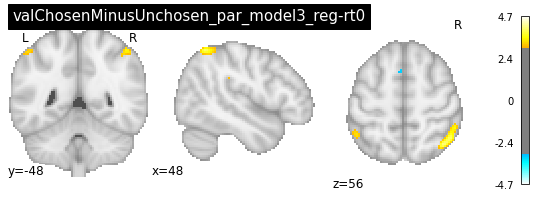

In [9]:
plot_filt_tval_img('valChosenMinusUnchosen_par', mnum = '3', nofilt=True, t_threshold=3, 
                   interactive=False, cut_coords = (48, -48, 56), draw_cross=False)

# Model 4: Model 2 + valBundleSum_par + valChosenMinusUnchosenLate_par + reward_ev + reward_par + rpeLeftRightSumEarly_par

In [ ]:
regs = ['valBundleSum_par', 'valChosenMinusUnchosenLate_par', 'reward_par', 'rpeLeftRightSumEarly_par']
mnum = '4'
for reg in regs:
    plot_filt_tval_img(reg, mnum = mnum)

In [ ]:
plot_filt_tval_img("valChosenMinusUnchosenLate_par", mnum = "4", nofilt=True, t_threshold=3, cut_coords=(-52, -48, 48))
plot_filt_tval_img("valChosenMinusUnchosenLate_par", mnum = "4", nofilt=True, t_threshold=3, cut_coords=(24, 12, 6))
plot_filt_tval_img("rpeLeftRightSumEarly_par", mnum = "4", nofilt=True, t_threshold=3)

# Model 5: Model 2 + valBundleSum_par + valChosenMinusUnchosenLate_par + reward_ev + reward_par + rpeLeftRightSumLate_par

In [ ]:
regs = ['valBundleSum_par', 'valChosenMinusUnchosenLate_par', 'reward_par', 'rpeLeftRightSumLate_par']
mnum = '5'
for reg in regs:
    plot_filt_tval_img(reg, mnum = mnum)

In [ ]:
plot_filt_tval_img("valChosenMinusUnchosenLate_par", mnum = "5", nofilt=True, t_threshold=3)
plot_filt_tval_img("rpeLeftRightSumLate_par", mnum = "5", nofilt=True, t_threshold=3)

# Model 6: what happens to rpe without reward_par - nothing. Still doesn't survive.

In [ ]:
regs = ['valBundleSum_par', 'valChosenMinusUnchosen_par', 'rpeLeftRightSum_par']
mnum = '6'
for reg in regs:
    plot_filt_tval_img(reg, mnum = mnum)

In [ ]:
plot_filt_tval_img("rpeLeftRightSum_par", mnum = "6", nofilt=True, t_threshold=2.3)
plot_filt_tval_img("valChosenMinusUnchosen_par", mnum = "6", nofilt=True, t_threshold=3)

# Model 7: Does anything for rpe survive with only one fractal included? No.

In [ ]:
regs = ['valBundleSum_par', 'valChosenMinusUnchosen_par', 'reward_par', 'rpeLeftFractal_par']
mnum = '7'
for reg in regs:
    plot_filt_tval_img(reg, mnum = mnum)

In [ ]:
plot_filt_tval_img("rpeLeftFractal_par", mnum = "9", nofilt=True, t_threshold=3)

# To solve

- Value comparison
- Signal for learning (RPE)
    - Same RPE regressor for all subjects using average parameter estimates?
- Parametric reward
    - Reward par for rewarded vs not rewarded contrast?